Hannah's notebook to mess around with GCNs for lorenz. WORK IN PROGRESS. (My computer broke so I have to use the computer lab and save all my incremental changes somewhere.)

### imports


In [44]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from spektral.layers import GCNConv, GlobalSumPool
from spektral.models import GCN
from spektral.data import MixedLoader
from lorenz import lorenzDataset, plot_with_predictions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### prepare data


In [45]:
DEFAULT_TIME_RESOLUTION = 0.01

THINGS TO TRY 
write helper functions! 
- play with diff sample size (500) - v
- input/output day ratio - h 
- play around with buffer - v
- activation layers - h
- play with the hidden layers - v 
- diff data samples / diff lorenz params - h 
- diff optimizer alg - v 

In [61]:
# TODO: add logging to see progress
dataset = lorenzDataset(
    n_samples=500,
    input_steps=5 / DEFAULT_TIME_RESOLUTION,  # 2 days
    output_delay=1 / DEFAULT_TIME_RESOLUTION,  # 1 day
    output_steps=1,
    min_buffer=10,
    rand_buffer=False,
    K=36,
    F=8,
    c=10,
    b=10,
    h=1,
    coupled=True,
    time_resolution=DEFAULT_TIME_RESOLUTION,
    seed=42)

In [47]:
# inspect dataset
print(dataset)
print(dataset[0])

lorenzDataset(n_graphs=200)
Graph(n_nodes=36, n_node_features=1000, n_edge_features=None, n_labels=1)


In [62]:
# split test/train data
# we can't use the keras split_dataset() function here because our Dataset
# class is incompatible
# we also cannot shuffle our data
train = dataset[:int(0.7 * dataset.n_graphs)]
val = dataset[int(0.7 * dataset.n_graphs):int(0.9 * dataset.n_graphs)]
test = dataset[int(0.9 * dataset.n_graphs):]

train_loader = MixedLoader(dataset=train, batch_size=32)
val_loader = MixedLoader(dataset=val, batch_size=32)
test_loader = MixedLoader(dataset=test, batch_size=32)

In [63]:
# normalize the data using the training set's mean and stdev
# TODO: verify that get_mean_std() is actually correct
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

X1_mean 2.3425825768770845
X1_std 3.514720102657398
X2_mean 0.08310268696575422
X2_std 0.2444872080016642


In [64]:
# check that the normalization was successful, i.e. the train data should have
# a mean of exactly 0 and a stdev of exactly 1; val and test should have means
# near 0 and stdevs near 1
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('statistics for train set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = val.get_mean_std()
print('\nstatistics for val set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = test.get_mean_std()
print('\nstatistics for test set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)


statistics for train set
X1_mean -5.775520662354044e-16
X1_std 1.0000000000000004
X2_mean 4.460088030822272e-16
X2_std 0.9999999999999992

statistics for val set
X1_mean -0.0037862852961002332
X1_std 0.9966687353520945
X2_mean -0.0034121242194541956
X2_std 0.989239475880252

statistics for test set
X1_mean 0.0027383349899078187
X1_std 1.0002826262638873
X2_mean 0.0017227274757064493
X2_std 1.0017306550064093


#### inspect our data

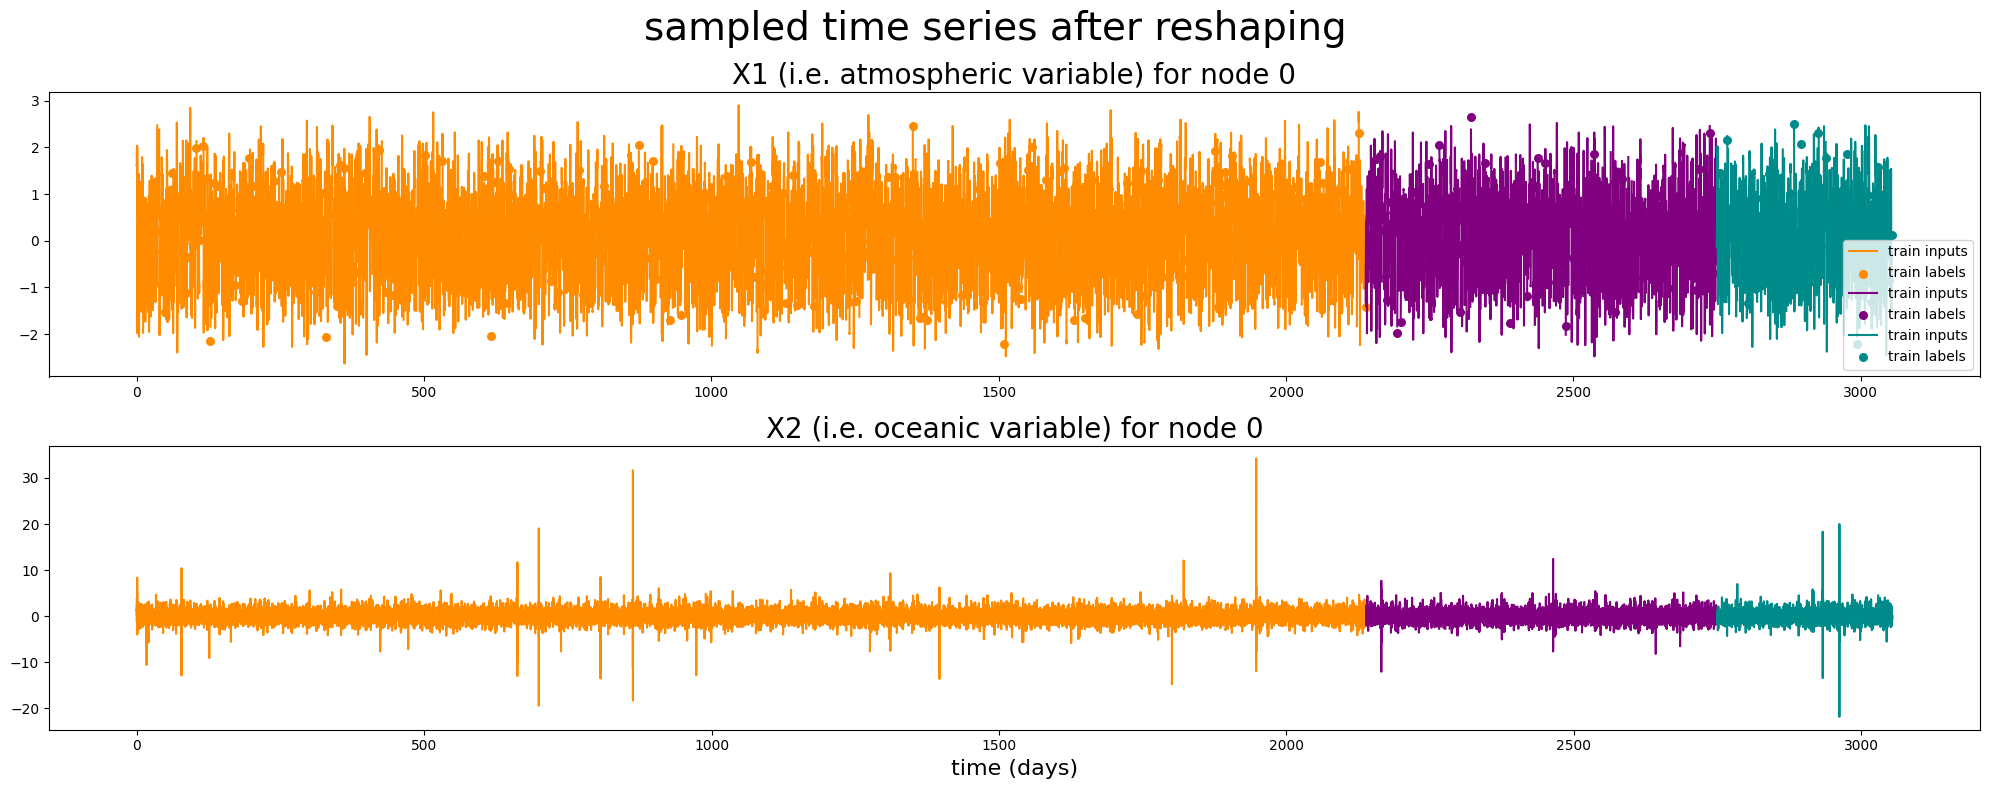

In [74]:
colors = ["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node,
                             fig,
                             ax0,
                             ax1,
                             data_type='train',
                             color=colors[0])
fig, (ax0, ax1) = val.plot(node,
                           fig,
                           ax0,
                           ax1,
                           data_type='val',
                           color=colors[1])
fig, (ax0, ax1) = test.plot(node,
                            fig,
                            ax0,
                            ax1,
                            data_type='test',
                            color=colors[2])

# create legend
ax0.legend()
ax0.legend(handles=ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[
    leg.legendHandles[i].set_color(colors[i // 2])
    for i in range(len(leg.legendHandles))
]

plt.tight_layout()
plt.show()

### out-of-the-box GCN

#### sanity check: initial error is reasonable

our final layer is a linear function. therefore, for the first epoch, when all our weights are initialized randomly and we set the regularization to 0, we would expect the error to be: ???

In [52]:
sanity_check_model1 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model1.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10


/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


5/5 [==============================] - 1s 10ms/step - loss: 23.9470 - mean_squared_error: 23.9470 - root_mean_squared_error: 4.8936
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 11.8594 - mean_squared_error: 11.8594 - root_mean_squared_error: 3.4438
Epoch 3/10
5/5 [==============================] - 0s 9ms/step - loss: 6.2617 - mean_squared_error: 6.2617 - root_mean_squared_error: 2.5023
Epoch 4/10
5/5 [==============================] - 0s 8ms/step - loss: 5.6532 - mean_squared_error: 5.6532 - root_mean_squared_error: 2.3777
Epoch 5/10
5/5 [==============================] - 0s 9ms/step - loss: 3.9309 - mean_squared_error: 3.9309 - root_mean_squared_error: 1.9827
Epoch 6/10
5/5 [==============================] - 0s 8ms/step - loss: 3.2417 - mean_squared_error: 3.2417 - root_mean_squared_error: 1.8005
Epoch 7/10
5/5 [==============================] - 0s 8ms/step - loss: 2.7273 - mean_squared_error: 2.7273 - root_mean_squared_error: 1.6515
Epoch 8/10
5/5 [==========

#### sanity check: increasing regularization causes increasing loss

regularization reduces the amount of overfitting, thus increasing the loss on the training set

In [53]:
sanity_check_model2 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0.5,
    l2_reg=5e-4)
sanity_check_model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[MeanSquaredError(), RootMeanSquaredError()])
history = sanity_check_model2.fit(train_loader.load(),
                                  steps_per_epoch=train_loader.steps_per_epoch,
                                  epochs=10)


Epoch 1/10
5/5 [==============================] - 1s 11ms/step - loss: 53.8505 - mean_squared_error: 53.8199 - root_mean_squared_error: 7.3362
Epoch 2/10
5/5 [==============================] - 0s 11ms/step - loss: 43.9083 - mean_squared_error: 43.8780 - root_mean_squared_error: 6.6240
Epoch 3/10
5/5 [==============================] - 0s 12ms/step - loss: 35.4060 - mean_squared_error: 35.3760 - root_mean_squared_error: 5.9478
Epoch 4/10
5/5 [==============================] - 0s 11ms/step - loss: 34.8296 - mean_squared_error: 34.7998 - root_mean_squared_error: 5.8991
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 31.2504 - mean_squared_error: 31.2209 - root_mean_squared_error: 5.5876
Epoch 6/10
5/5 [==============================] - 0s 11ms/step - loss: 28.5712 - mean_squared_error: 28.5419 - root_mean_squared_error: 5.3425
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 25.1776 - mean_squared_error: 25.1485 - root_mean_squared_error: 5.0148

yep, the error with an L2 regularization of 5e-4 is higher than the error when the L2 regularzation was 0. 

#### sanity check 3: model can overfit

using 20 samples and setting regularization to 0, we want to make sure we can actually get to 0 error. 

(we also set dropout to 0 since dropout is supposed to help avoid overfitting.)

In [73]:
train

lorenzDataset(n_graphs=350)

In [71]:
overfit_sample = train[:20]
overfit_loader = MixedLoader(dataset=overfit_sample, batch_size=20)

sanity_check_model3 = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None,
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
sanity_check_model3.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = sanity_check_model3.fit(
    overfit_loader.load(),
    steps_per_epoch=overfit_loader.steps_per_epoch,
    epochs=2000)


Epoch 1/2000
1/1 [==============================] - 1s 683ms/step - loss: 15.5679
Epoch 2/2000
1/1 [==============================] - 0s 5ms/step - loss: 8.4292
Epoch 3/2000
1/1 [==============================] - 0s 13ms/step - loss: 6.0083
Epoch 4/2000
1/1 [==============================] - 0s 12ms/step - loss: 4.8571
Epoch 5/2000
1/1 [==============================] - 0s 9ms/step - loss: 4.1585
Epoch 6/2000
1/1 [==============================] - 0s 13ms/step - loss: 3.6994
Epoch 7/2000
1/1 [==============================] - 0s 9ms/step - loss: 3.3924
Epoch 8/2000
1/1 [==============================] - 0s 5ms/step - loss: 3.0982
Epoch 9/2000
1/1 [==============================] - 0s 8ms/step - loss: 2.7570
Epoch 10/2000
1/1 [==============================] - 0s 9ms/step - loss: 2.4161
Epoch 11/2000
1/1 [==============================] - 0s 5ms/step - loss: 2.1149
Epoch 12/2000
1/1 [==============================] - 0s 8ms/step - loss: 1.8647
Epoch 13/2000
1/1 [========================

the MSE got down to around 0.2ish by epoch 1000; however, after that, it fluctuated between  0.2 to 1 ish and didn't seem to ever get under 0.2. 

Is this good enough?

let's visualize the predictions

1/1 [==============================] - 0s 173ms/step


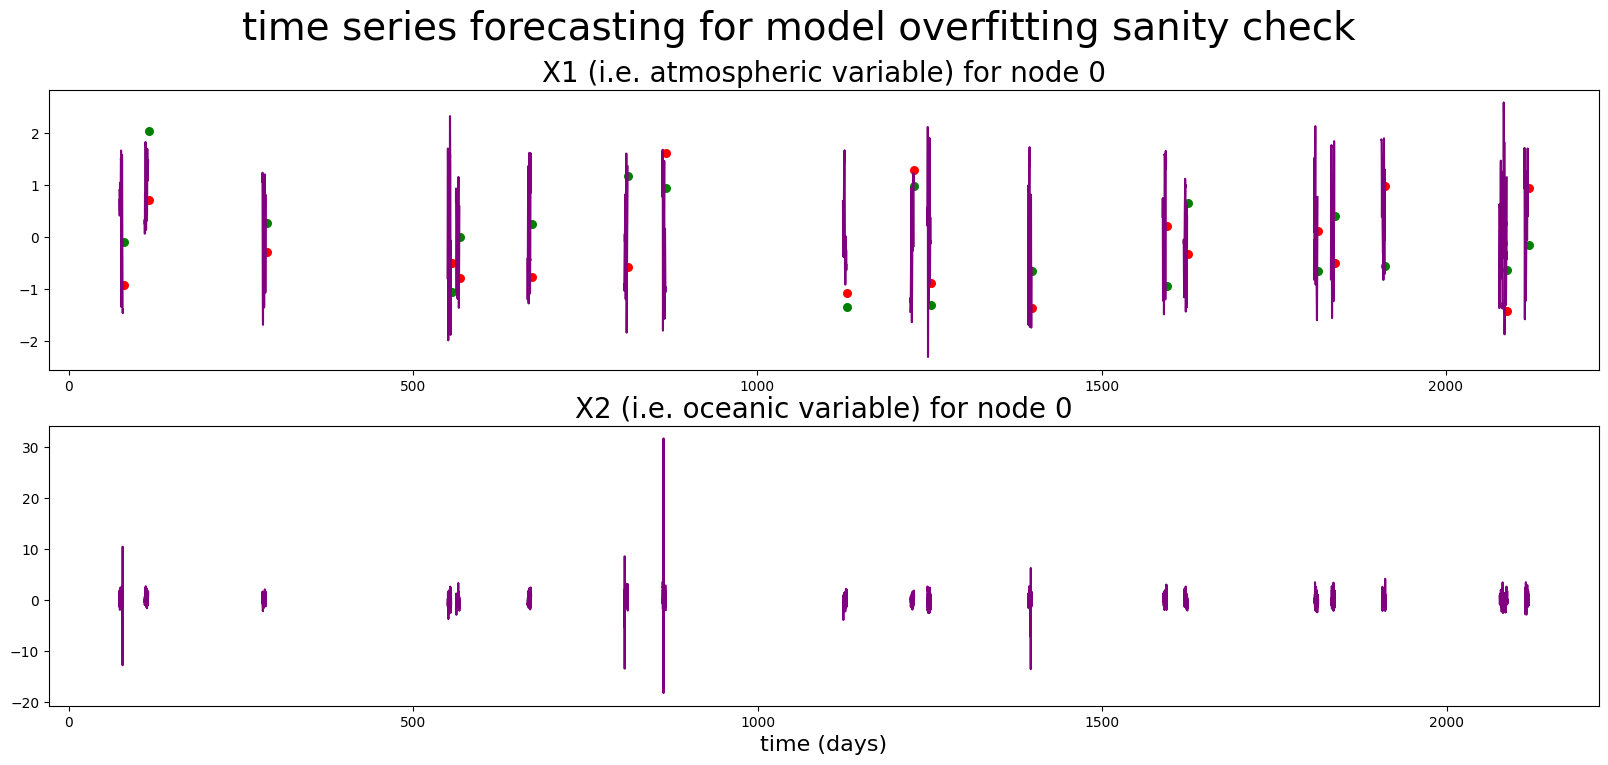

In [72]:
fig, (ax0, ax1) = plot_with_predictions(model=sanity_check_model3,
                                        graph_dataset=overfit_sample,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='overfitting sanity check')
plt.show()

### train GCN model

In [65]:
GCN_model = GCN(
    n_labels=1,
    channels=32,  # same thing as n_hidden
    activation="relu",
    output_activation=None, # we want regression, i.e. a linear function
    use_bias=False,
    dropout_rate=0,
    l2_reg=0)
GCN_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = GCN_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=200)

Epoch 1/200


/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


11/11 [==============================] - 1s 9ms/step - loss: 16.8261
Epoch 2/200
11/11 [==============================] - 0s 11ms/step - loss: 5.9368
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 3.7497
Epoch 4/200
11/11 [==============================] - 0s 10ms/step - loss: 2.8243
Epoch 5/200
11/11 [==============================] - 0s 11ms/step - loss: 2.4211
Epoch 6/200
11/11 [==============================] - 0s 10ms/step - loss: 2.1418
Epoch 7/200
11/11 [==============================] - 0s 10ms/step - loss: 1.8858
Epoch 8/200
11/11 [==============================] - 0s 10ms/step - loss: 1.7056
Epoch 9/200
11/11 [==============================] - 0s 10ms/step - loss: 1.6092
Epoch 10/200
11/11 [==============================] - 0s 10ms/step - loss: 1.5260
Epoch 11/200
11/11 [==============================] - 0s 11ms/step - loss: 1.4723
Epoch 12/200
11/11 [==============================] - 0s 10ms/step - loss: 1.4216
Epoch 13/200
11/11 [=================

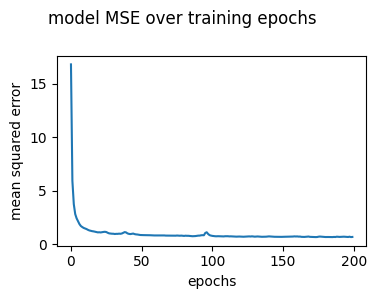

In [66]:
# print(type(history.history))
# print(history.history)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(history.history['loss'])
ax.set_ylabel('mean squared error')
ax.set_xlabel('epochs')
fig.suptitle('model MSE over training epochs')
plt.tight_layout()
plt.show()

### GCN predictions

visualize predictions on the training set

11/11 [==============================] - 0s 8ms/step


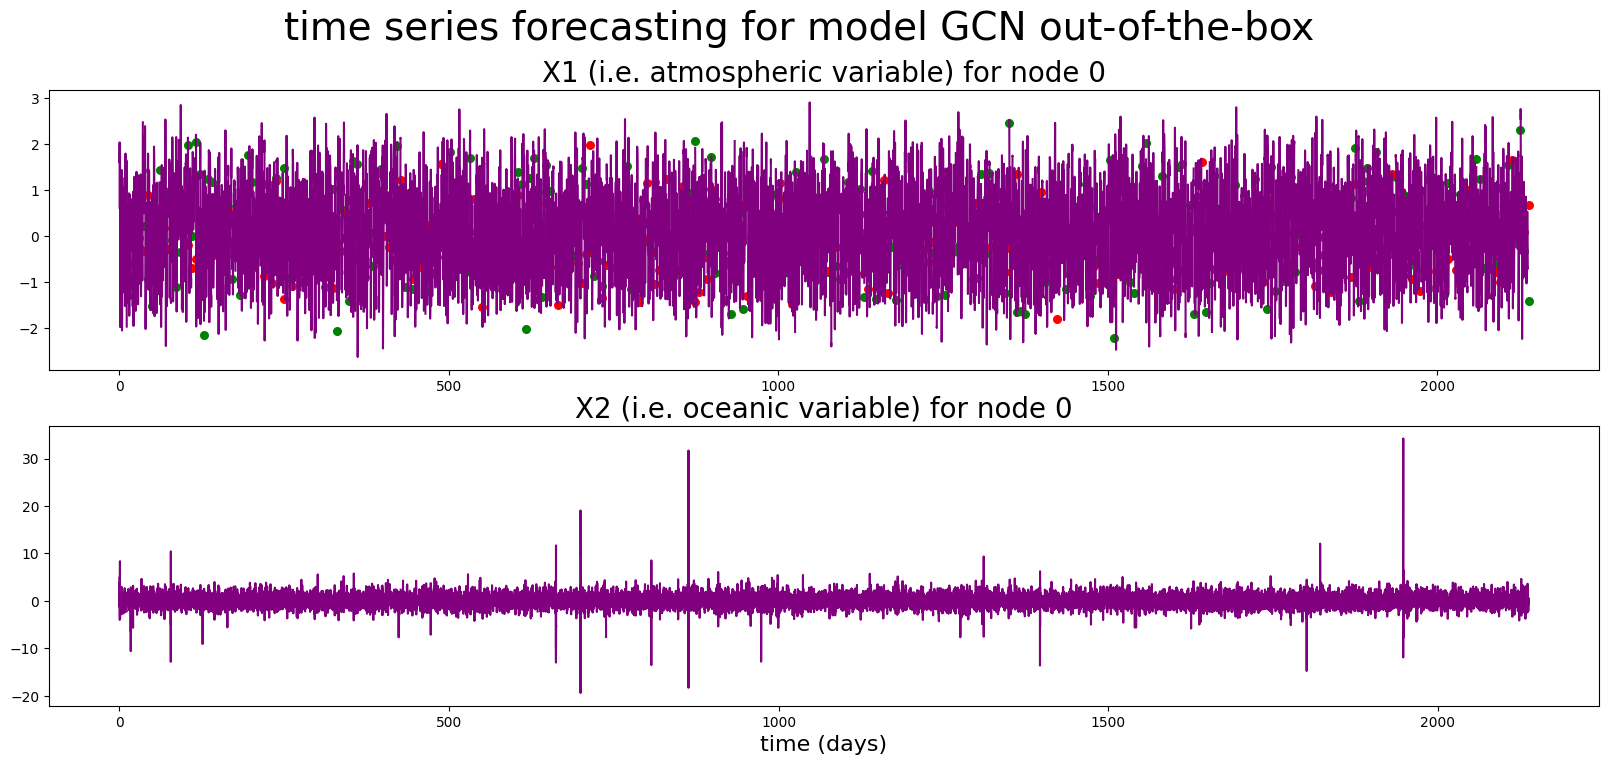

In [67]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=train,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

these predictions are... pretty bad, lol

also, why are we seeing np.shuffle() being called? where is that occurring?

visualize predictions for the validation set

4/4 [==============================] - 0s 9ms/step


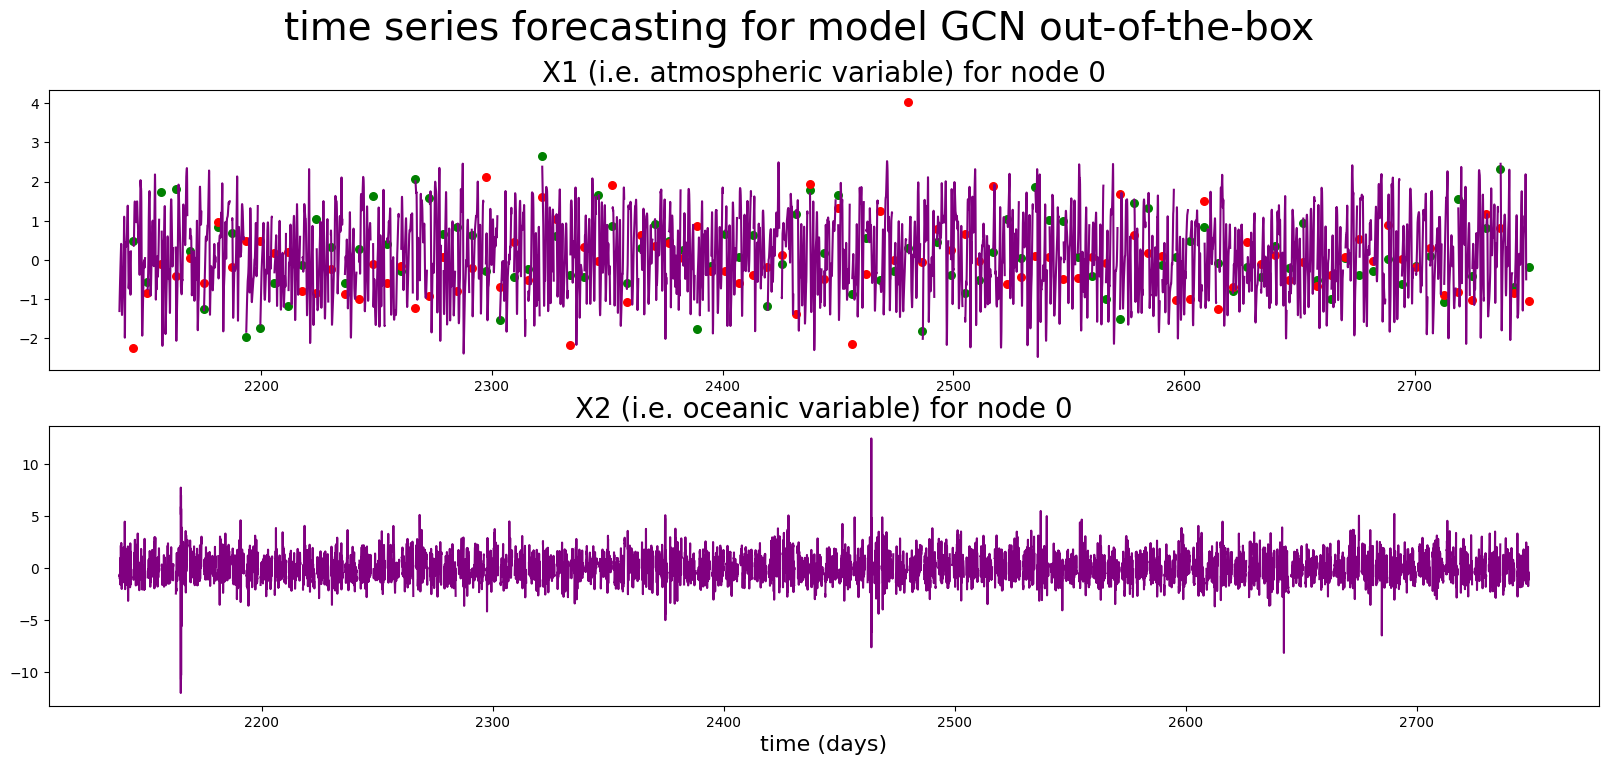

In [68]:
fig, (ax0, ax1) = plot_with_predictions(model=GCN_model,
                                        graph_dataset=val,
                                        Loader=MixedLoader,
                                        batch_size=32,
                                        node=0,
                                        model_name='GCN out-of-the-box')
plt.show()

In [ ]:
# TODO: try some different training parameters 
# TODO: try this with continuous windowing and compare this with LSTM ? 

## custom GCN

### define custom model

In [ ]:
class customGCN(Model):
    # TODO: something is going super wrong here
    def __init__(self, n_hidden, output_dim, dropout=0.5):
        super().__init__()
        self.gcn0 = GCNConv(n_hidden, activation='relu')
        self.gcn1 = GCNConv(n_hidden, activation='relu')
        self.pool = GlobalSumPool()
        self.dropout0 = Dropout(dropout)
        self.dropout1 = Dropout(dropout)
        self.dense = Dense(units=output_dim,
                           activation=None)  # linear regression layer

    def call(self, inputs):
        # print(type(inputs))
        # print(len(inputs))
        # print('\n\n')
        # print(inputs)
        x, a = inputs
        x = self.dropout0(x)
        x = self.gcn0([x, a])
        x = self.dropout1(x)
        x = self.gcn1([x, a])
        x = self.pool(x)
        out = self.dense(x)
        return out

In [ ]:
custom_model = customGCN(n_hidden=32,
                         output_dim=dataset[0].y.shape[-1],
                         dropout=0.5)
custom_model.compile(
    optimizer='adam',
    loss='mean_squared_error')
history = custom_model.fit(
    train_loader.load(),
    steps_per_epoch=train_loader.steps_per_epoch,
    epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 5ms/step - loss: 9220.6973
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 1909.1207
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 2084.3423
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 2302.6650
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 3120.4397
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 934.5153
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 1362.0967
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 1992.3489
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 1355.3508
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 761.1311
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 1100.0125
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 940.1588
Epoch 13/100
3/3 [==========